In [1]:
# Uploading the file into the environment
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [3]:
# Loading the dataset
import pandas as pd
df = pd.read_csv(list(uploaded.keys())[0])

In [4]:
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Check for missing values
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [7]:
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [8]:
# Checking distribution of categorical values
print(df['sex'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


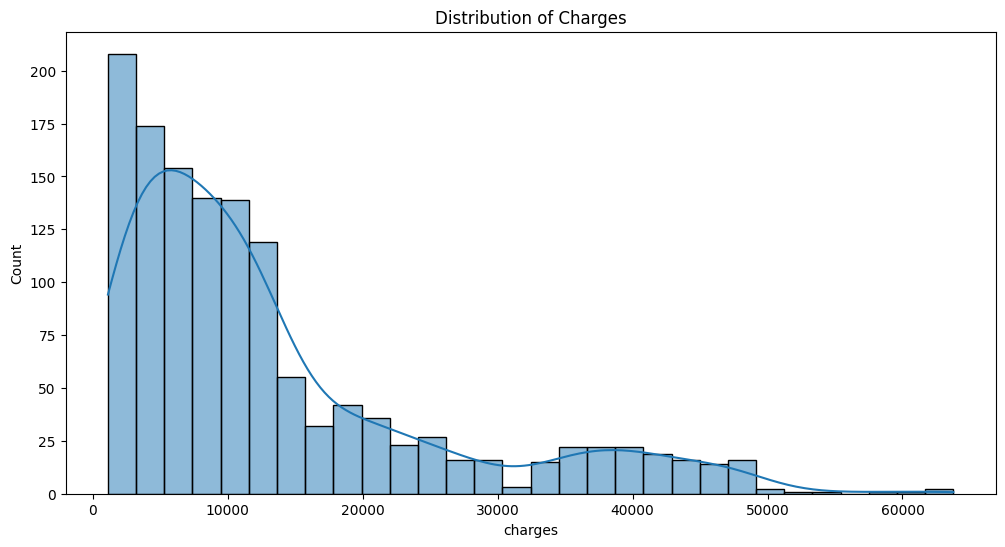

In [15]:
# visualizing the distribution of charges
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.histplot(df['charges'], kde = True, bins = 30)
plt.title('Distribution of Charges')
plt.show()

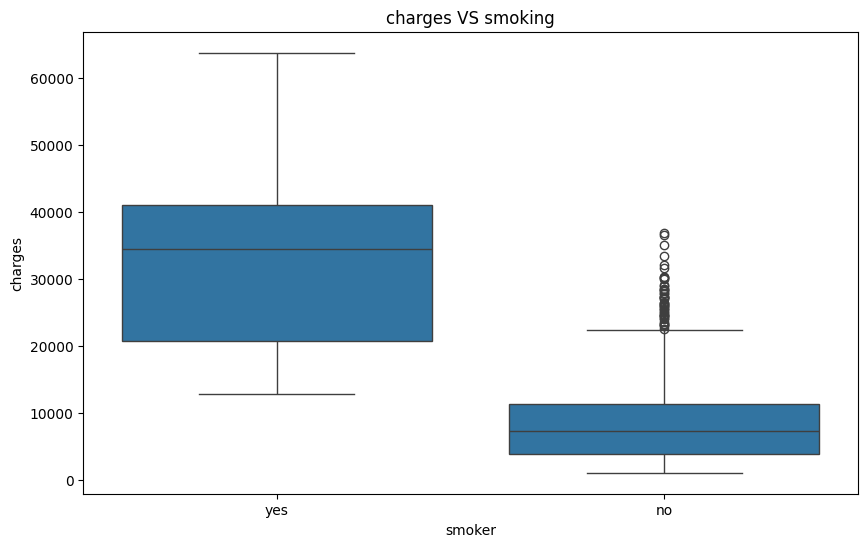

In [18]:
#relationship between smoker and charges
plt.figure(figsize=(10,6))
sns.boxplot(x='smoker', y='charges', data= df)
plt.title('charges VS smoking')
plt.show()

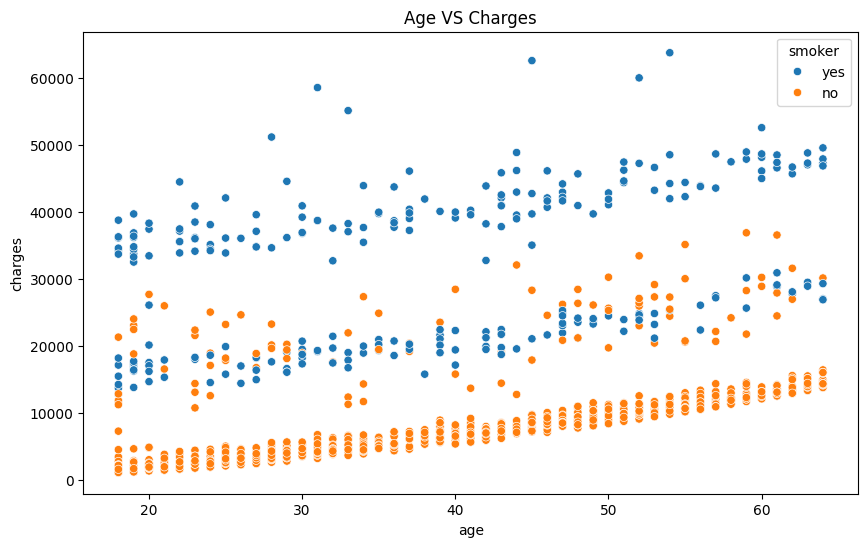

In [19]:
# relationship between age and charges
plt.figure(figsize=(10,6))
sns.scatterplot(x='age', y='charges', data = df, hue='smoker')
plt.title('Age VS Charges')
plt.show()

In [21]:
# Encoding the categorical columns
df_encoded = pd.get_dummies(df, columns=['sex','smoker', 'region'], drop_first = True)

df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


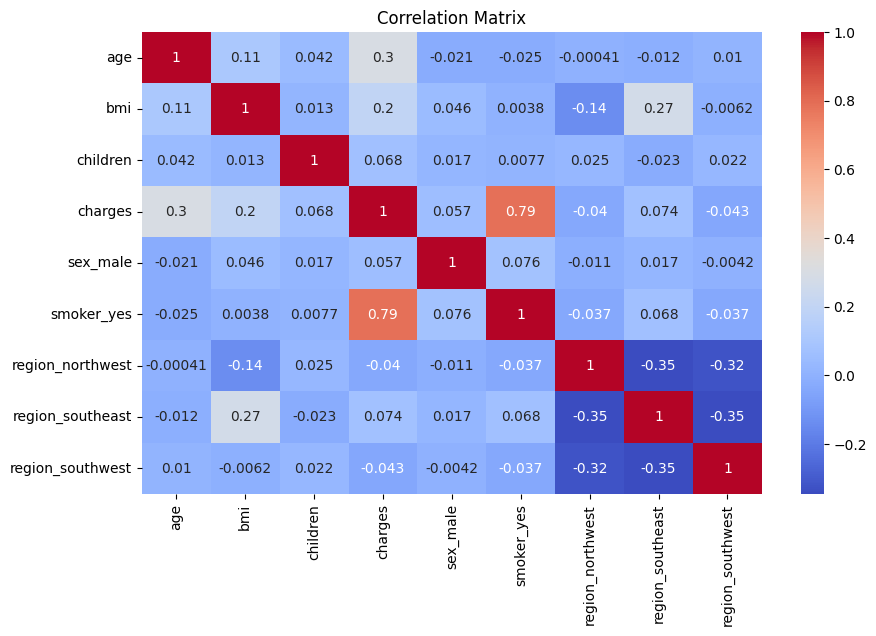

In [22]:
# Correlation Matrix
correlation_matrix_encoded = df_encoded.corr()

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix_encoded, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [24]:
#Handling Outliers

Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['charges'] >= lower_bound) & (df['charges'] <= upper_bound)]

print('Orginal dataset size:', df.shape)
print('Filtered dataset size:', df_filtered.shape)

Orginal dataset size: (1338, 7)
Filtered dataset size: (1199, 7)


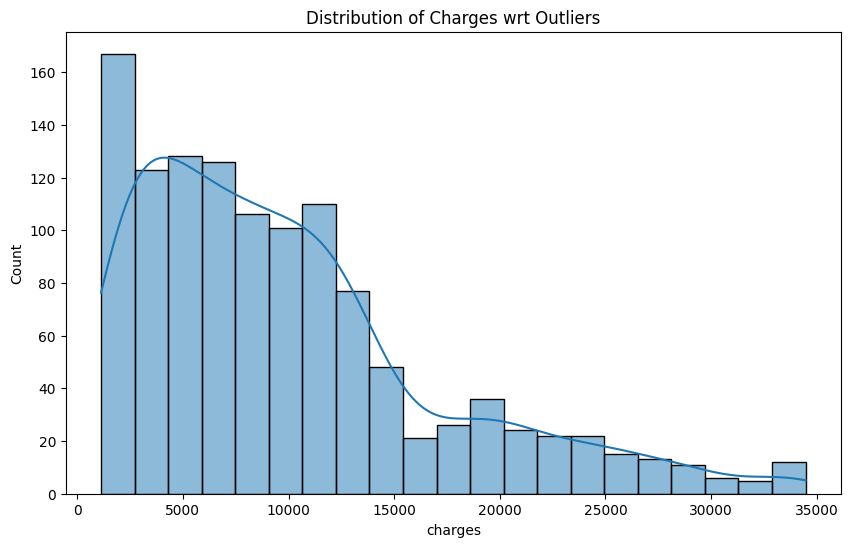

In [28]:
#Visualizing to check for outliers
plt.figure(figsize=(10,6))
sns.histplot(df_filtered['charges'], kde = 2)
plt.title('Distribution of Charges wrt Outliers')
plt.show()

In [29]:
#Building the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Separating the features and the target variable
X = df_encoded.drop('charges', axis = 1)
y = df_encoded['charges']

# Splitting the dataset into 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Initialize the model
model = LinearRegression()

#Training
model.fit(X_train,y_train)

#making predictions
y_pred = model.predict(X_test)

#Evalusting the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Sq Error: ', mse)
print('R2 sq: ', r2)

Mean Sq Error:  33596915.85136145
R2 sq:  0.7835929767120724


In [30]:
#Feature Engineering
from sklearn.preprocessing import PolynomialFeatures

# Interaction terms: Interaction between two or more features.
# For instance, "age × smoker" could represent the joint impact of age and smoking status on charges.

# Polynomial features: Adding non-linear terms like squares or cubes of features
# (e.g., age², BMI²) to capture potential non-linear relationships.

poly = PolynomialFeatures(degree=2, interaction_only= False, include_bias =False)
poly_features = poly.fit_transform(df_encoded[['age','bmi','children']])

#Get feature names for the new polynomial features
poly_feature_names = poly.get_feature_names_out(['age','bmi','children'])

#Creating Df with new features
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

#Appending the dataframe to existing Df
df_extended = pd.concat([df_encoded, poly_df], axis=1)

print(df_extended.head())

   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest   age     bmi  children   age^2  \
0             False              True  19.0  27.900       0.0   361.0   
1              True             False  18.0  33.770       1.0   324.0   
2              True             False  28.0  33.000       3.0   784.0   
3             False             False  33.0  22.705       0.0  1089.0   
4             False             False  32.0  28.880       0.0  1024.0   

   age bmi  age children        bmi^2  bmi children  children^2  
0  530.1

In [31]:
#Ridge and Lasso
from sklearn.linear_model import Ridge, Lasso

#Separating the features and target variable

X = df_extended.drop(columns=['charges'])
y = df_extended['charges']

#Splitting the extended dataset into 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train,y_train)
ridge_preds = ridge.predict(X_test)

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

In [32]:
#Ridge metrics
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)
print("Ridge MSE: ", ridge_mse)
print("Ridge R2: ", ridge_r2)

#Lasso metrics
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)
print('Lasso MSE: ', lasso_mse)
print('Lasso R2: ', lasso_r2)

Ridge MSE:  34171440.10736624
Ridge R2:  0.7798923071446999
Lasso MSE:  34118150.23717551
Lasso R2:  0.7802355619312522


In [38]:
#cross-validation
from sklearn.model_selection import cross_val_score

#cross-validation for Ridge
ridge_cv_scores = cross_val_score(ridge, X, y, cv=5, scoring='r2')
print("Ridge CV R2 Scores:", ridge_cv_scores)
print("Ridge CV R2 Mean:", ridge_cv_scores.mean())

#cross-validation for Lasso
lasso_cv_scores = cross_val_score(lasso, X, y, cv=5, scoring='r2')
print("Lasso CV R2 Scores:", lasso_cv_scores)
print("Lasso CV R2 Mean:", lasso_cv_scores.mean())

Ridge CV R2 Scores: [0.76445222 0.71244707 0.77054872 0.73679204 0.76106845]
Ridge CV R2 Mean: 0.7490617010238972
Lasso CV R2 Scores: [0.76432533 0.71214527 0.77126029 0.73650202 0.76128683]
Lasso CV R2 Mean: 0.7491039497532717
